# T-SNE Tutorial (Source: https://github.com/oreillymedia/t-SNE-tutorial)

## Imports

In [1]:
# That's an impressive list of imports.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)
from sklearn.utils.extmath import _ravel
# Random state.
RS = 20150101

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

# We'll generate an animation with matplotlib and moviepy.
from moviepy.video.io.bindings import mplfig_to_npimage
import moviepy.editor as mpy

## Loading digits

In [2]:
digits = load_digits()
digits.data.shape

(1797, 64)

In [3]:
print(digits['DESCR'])

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

## Plotting digit images

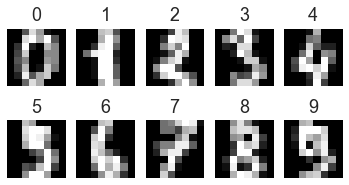

In [4]:
nrows, ncols = 2, 5
plt.figure(figsize=(6,3))
plt.gray()
for i in range(ncols * nrows):
    ax = plt.subplot(nrows, ncols, i + 1)
    ax.matshow(digits.images[i,...])
    plt.xticks([]); plt.yticks([])
    plt.title(digits.target[i])
plt.savefig('images/digits-generated.png', dpi=150)

## Running the t-SNE algorithm on the dataset (one line with scikit-learn)

In [5]:
# We first reorder the data points according to the handwritten numbers.
X = np.vstack([digits.data[digits.target==i]
               for i in range(10)])
y = np.hstack([digits.target[digits.target==i]
               for i in range(10)])
digits_proj = TSNE(random_state=RS).fit_transform(X)

In [6]:
digits_proj = TSNE(random_state=RS).fit_transform(X)

"Here is a utility function used to display the transformed dataset. The color of each point refers to the actual digit (of course, this information was not used by the dimensionality reduction algorithm)."

In [7]:
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

## Scatter plot

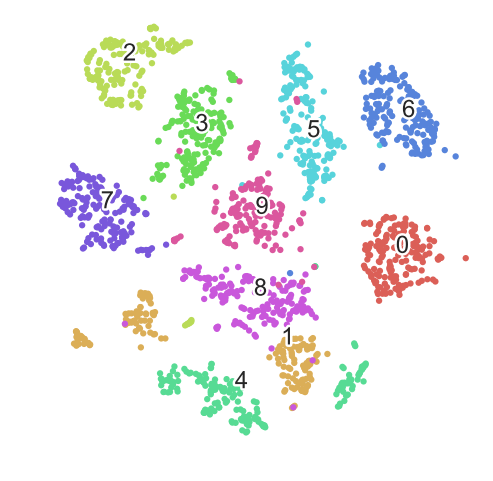

In [8]:
scatter(digits_proj, y)
plt.savefig('images/digits_tsne-generated.png', dpi=120)

"We observe that the images corresponding to the different digits are clearly separated into different clusters of points."

## Mathematical framework

Let's explain how the algorithm works. First, a few definitions.

A data point is a point $x_i$ in the original data space $\mathbf{R}^D$, where $D=64$ is the dimensionality of the data space. Every point is an image of a handwritten digit here. There are $N=1797$ points.

A map point is a point $(y_i)$ in the map space $\mathbf{R}^2$. This space will contain our final representation of the dataset. There is a bijection between the data points and the map points: every map point represents one of the original images.

How do we choose the positions of the map points? We want to conserve the structure of the data. More specifically, if two data points are close together, we want the two corresponding map points to be close too. Let's $(\left| x_i - x_j \right|)$ be the Euclidean distance between two data points, and $\left| y_i - y_j \right|$ the distance between the map points. We first define a conditional similarity between the two data points:

$p_{j|i} = \frac{\exp\left(-\left| x_i - x_j\right|^2 \big/ 2\sigma_i^2\right)}{\displaystyle\sum_{k \neq i} \exp\left(-\left| x_i - x_k\right|^2 \big/ 2\sigma_i^2\right)}$

This measures how close $x_j$ is from $x_i$, considering a Gaussian distribution around $x_i$ with a given variance $\sigma_i^2$. This variance is different for every point; it is chosen such that points in dense areas are given a smaller variance than points in sparse areas. The original paper details how this variance is computed exactly.

Now, we define the similarity as a symmetrized version of the conditional similarity:

$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$

We obtain a similarity matrix for our original dataset. What does this matrix look like?

## Similarity matrix

The following function computes the similarity with a constant \(\sigma\).

In [9]:
def _joint_probabilities_constant_sigma(D, sigma):
    P = np.exp(-D**2/2 * sigma**2)
    P /= np.sum(P, axis=1)
    return P

We now compute the similarity with a \(\sigma_i\) depending on the data point (found via a binary search, according to the original t-SNE paper). This algorithm is implemented in the _joint_probabilities private function in scikit-learn's code.

In [10]:
# Pairwise distances between all data points.
D = pairwise_distances(X, squared=True)
# Similarity with constant sigma.
P_constant = _joint_probabilities_constant_sigma(D, .002)
# Similarity with variable sigma.
P_binary = _joint_probabilities(D, 30., False)
# The output of this function needs to be reshaped to a square matrix.
P_binary_s = squareform(P_binary)

We can now display the distance matrix of the data points, and the similarity matrix with both a constant and variable sigma.

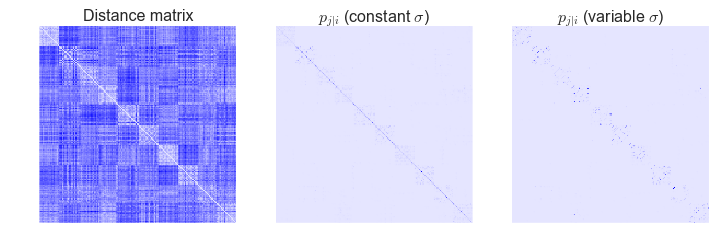

In [11]:
plt.figure(figsize=(12, 4))
pal = sns.light_palette("blue", as_cmap=True)

plt.subplot(131)
plt.imshow(D[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("Distance matrix", fontdict={'fontsize': 16})

plt.subplot(132)
plt.imshow(P_constant[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (constant $\sigma$)", fontdict={'fontsize': 16})

plt.subplot(133)
plt.imshow(P_binary_s[::10, ::10], interpolation='none', cmap=pal)
plt.axis('off')
plt.title("$p_{j|i}$ (variable $\sigma$)", fontdict={'fontsize': 16})
plt.savefig('images/similarity-generated.png', dpi=120)

We can already observe the 10 groups in the data, corresponding to the 10 numbers.

Let's also define a similarity matrix for our map points.

$q_{ij} = \frac{f(\left| x_i - x_j\right|)}{\displaystyle\sum_{k \neq i} f(\left| x_i - x_k\right|)} \quad \textrm{with} \quad f(z) = \frac{1}{1+z^2}$

This is the same idea as for the data points, but with a different distribution (t-Student with one degree of freedom, or Cauchy distribution, instead of a Gaussian distribution). We'll elaborate on this choice later.

Whereas the data similarity matrix $\big(p_{ij}\big)$ is fixed, the map similarity matrix $\big(q_{ij}\big)$ depends on the map points. What we want is for these two matrices to be as close as possible. This would mean that similar data points yield similar map points.

## Physical analogy

Let's assume that our map points are all connected with springs. The stiffness of a spring connecting points \(i\) and \(j\) depends on the mismatch between the similarity of the two data points and the similarity of the two map points, that is, \(p_{ij} - q_{ij}\). Now, we let the system evolve according to the laws of physics. If two map points are far apart while the data points are close, they are attracted together. If they are nearby while the data points are dissimilar, they are repelled.

The final mapping is obtained when the equilibrium is reached.

Here is an illustration of a dynamic graph layout based on a similar idea. Nodes are connected via springs and the system evolves according to law of physics (example by Mike Bostock).



## Algorithm

Remarkably, this physical analogy stems naturally from the mathematical algorithm. It corresponds to minimizing the Kullback-Leiber divergence between the two distributions $\big(p_{ij}\big)$ and $\big(q_{ij}\big)$:

$KL(P||Q) = \sum_{i, j} p_{ij} \, \log \frac{p_{ij}}{q_{ij}}.$

This measures the distance between our two similarity matrices.

To minimize this score, we perform a gradient descent. The gradient can be computed analytically:

$\frac{\partial \, KL(P || Q)}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij}) g\left( \left| x_i - x_j\right| \right) u_{ij} \quad \textrm{where} \, g(z) = \frac{z}{1+z^2}.$

Here, $u_{ij}$ is a unit vector going from $y_j$ to $y_i$. This gradient expresses the sum of all spring forces applied to map point $i$.

Let's illustrate this process by creating an animation of the convergence. We'll have to monkey-patch the internal _gradient_descent() function from scikit-learn's t-SNE implementation in order to register the position of the map points at every iteration.

In [37]:
# This list will contain the positions of the map points at every iteration.
positions = []
def _gradient_descent(objective, p0, it, n_iter, objective_error=None, n_iter_check=1, n_iter_without_progress=30,
                      momentum=0.5, learning_rate=1000.0, min_gain=0.01,
                      min_grad_norm=1e-7, min_error_diff=1e-7, verbose=0,
                      args=[],kwargs=None):
    # The documentation of this function can be found in scikit-learn's code.
    p = p0.copy().ravel()
    update = np.zeros_like(p)
    gains = np.ones_like(p)
    error = np.finfo(np.float).max
    best_error = np.finfo(np.float).max
    best_iter = 0

    for i in range(it, n_iter):
        # We save the current position.
        positions.append(p.copy())

        new_error, grad = objective(p, *args)
        error_diff = np.abs(new_error - error)
        error = new_error
        grad_norm = linalg.norm(grad)

        if error < best_error:
            best_error = error
            best_iter = i
        elif i - best_iter > n_iter_without_progress:
            break
        if min_grad_norm >= grad_norm:
            break
        if min_error_diff >= error_diff:
            break

        inc = update * grad >= 0.0
        dec = np.invert(inc)
        gains[inc] += 0.05
        gains[dec] *= 0.95
        np.clip(gains, min_gain, np.inf)
        grad *= gains
        update = momentum * update - learning_rate * grad
        p += update

    return p, error, i

sklearn.manifold.t_sne._gradient_descent = _gradient_descent

Let's run the algorithm again, but this time saving all intermediate positions.

In [38]:
X_proj = TSNE(random_state=RS).fit_transform(X)

In [39]:
X_iter = np.dstack(position.reshape(-1, 2)
                   for position in positions)

We create an animation using MoviePy.


[MoviePy] >>>> Building file images/animation.gif
[MoviePy] Generating GIF frames...






  0%|          | 0/2 [00:00<?, ?it/s]



100%|██████████| 2/2 [00:00<00:00, 27.59it/s]

[MoviePy] >>>> File images/animation.gif is ready !

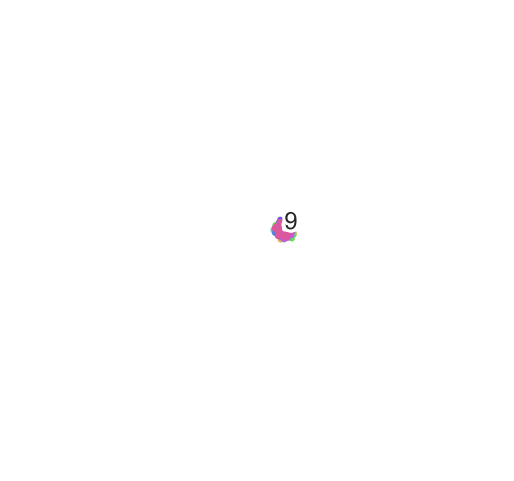

In [42]:
f, ax, sc, txts = scatter(X_iter[..., -1], y)

def make_frame_mpl(t):
    i = int(t*40)
    x = X_iter[..., i]
    sc.set_offsets(x)
    for j, txt in zip(range(10), txts):
        xtext, ytext = np.median(x[y == j, :], axis=0)
        txt.set_x(xtext)
        txt.set_y(ytext)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)

animation.write_gif("images/animation.gif", fps=20, program= 'ffmpeg')

We can clearly observe the different phases of the optimization, as described in the original paper.

Let's also create an animation of the similarity matrix of the map points. We'll observe that it's getting closer and closer to the similarity matrix of the data points.


[MoviePy] >>>> Building file images/animation_matrix.gif
[MoviePy] Generating GIF frames...


100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

[MoviePy] >>>> File images/animation_matrix.gif is ready !

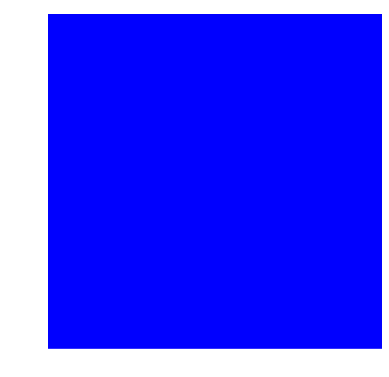

In [47]:
n = 1. / (pdist(X_iter[..., -1], "sqeuclidean") + 1)
Q = n / (2.0 * np.sum(n))
Q = squareform(Q)

f = plt.figure(figsize=(6, 6))
ax = plt.subplot(aspect='equal')
im = ax.imshow(Q, interpolation='none', cmap=pal)
plt.axis('tight')
plt.axis('off')

def make_frame_mpl(t):
    i = int(t*40)
    n = 1. / (pdist(X_iter[..., i], "sqeuclidean") + 1)
    Q = n / (2.0 * np.sum(n))
    Q = squareform(Q)
    im.set_data(Q)
    return mplfig_to_npimage(f)

animation = mpy.VideoClip(make_frame_mpl,
                          duration=X_iter.shape[2]/40.)
animation.write_gif("images/animation_matrix.gif",program= 'ffmpeg', fps=20)

## The t-Student distribution

Let's now explain the choice of the t-Student distribution for the map points, while a normal distribution is used for the data points. It is well known that the volume of the \(N\)-dimensional ball of radius \(r\) scales as \(r^N\). When \(N\) is large, if we pick random points uniformly in the ball, most points will be close to the surface, and very few will be near the center.

This is illustrated by the following simulation, showing the distribution of the distances of these points, for different dimensions.

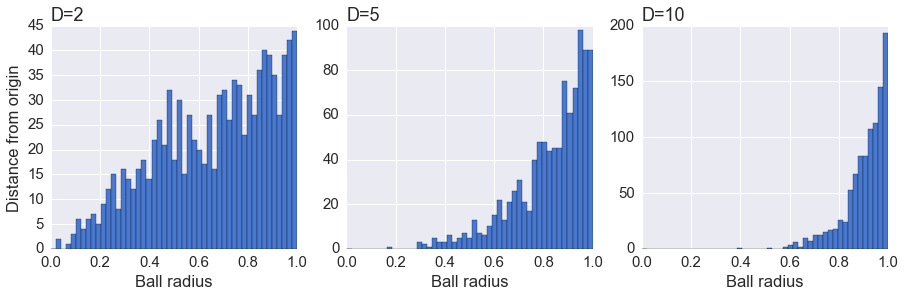

In [48]:
npoints = 1000
plt.figure(figsize=(15, 4))
for i, D in enumerate((2, 5, 10)):
    # Normally distributed points.
    u = np.random.randn(npoints, D)
    # Now on the sphere.
    u /= norm(u, axis=1)[:, None]
    # Uniform radius.
    r = np.random.rand(npoints, 1)
    # Uniformly within the ball.
    points = u * r**(1./D)
    # Plot.
    ax = plt.subplot(1, 3, i+1)
    ax.set_xlabel('Ball radius')
    if i == 0:
        ax.set_ylabel('Distance from origin')
    ax.hist(norm(points, axis=1),
            bins=np.linspace(0., 1., 50))
    ax.set_title('D=%d' % D, loc='left')
plt.savefig('images/spheres-generated.png', dpi=100, bbox_inches='tight')

When reducing the dimensionality of a dataset, if we used the same Gaussian distribution for the data points and the map points, we would get an imbalance in the distribution of the distances of a point's neighbors. This is because the distribution of the distances is so different between a high-dimensional space and a low-dimensional space. Yet, the algorithm tries to reproduce the same distances in the two spaces. This imbalance would lead to an excess of attraction forces and a sometimes unappealing mapping. This is actually what happens in the original SNE algorithm, by Hinton and Roweis (2002).

The t-SNE algorithm works around this problem by using a t-Student with one degree of freedom (or Cauchy) distribution for the map points. This distribution has a much heavier tail than the Gaussian distribution, which compensates the original imbalance. For a given similarity between two data points, the two corresponding map points will need to be much further apart in order for their similarity to match the data similarity. This can be seen in the following plot.

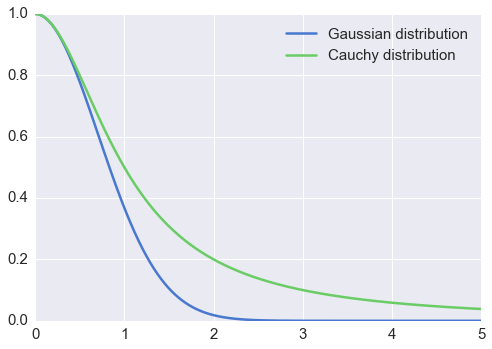

In [49]:
z = np.linspace(0., 5., 1000)
gauss = np.exp(-z**2)
cauchy = 1/(1+z**2)
plt.plot(z, gauss, label='Gaussian distribution')
plt.plot(z, cauchy, label='Cauchy distribution')
plt.legend()
plt.savefig('images/distributions-generated.png', dpi=100)

Using this distribution leads to more effective data visualizations, where clusters of points are more distinctly separated.

## Conclusion

The t-SNE algorithm provides an effective method to visualize a complex dataset. It successfully uncovers hidden structures in the data, exposing natural clusters and smooth nonlinear variations along the dimensions. It has been implemented in many languages, including Python, and it can be easily used thanks to the scikit-learn library.

The references below describe some optimizations and improvements that can be made to the algorithm and implementations. In particular, the algorithm described here is quadratic in the number of samples, which makes it unscalable to large datasets. One could for example obtain an \(O(N \log N)\) complexity by using the Barnes-Hut algorithm to accelerate the N-body simulation via a quadtree or an octree.